# Modelling and Evaluating

## Objectives

* Answer business requirement no.1:
the client is interested in conducting a study to visually differentiate a healthy cherry leaf from one that contains powdery mildew.

## Inputs
- image shape embeddings (pickle file)
- Images from the test, train, validation folders and their subfolders


## Outputs
- Images distribution plot in train, validation, and test set.
- Image augmentation. 
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.


## Comments
- The CNN was built seeking to maximize accuracy while kept as small as possible without compromising accuracy and avoiding overfitting.

---

### Import packages

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
import sklearn
import joblib
import matplotlib as mpl
import pathlib
from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

## Set working directory

In [39]:
current_dir = os.getcwd()
current_dir

'C:\\Users\\hnsaa\\Projects\\P5\\Mildew_Detection_in_Cherry_Leaves'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'C:\\Users\\hnsaa\\Projects\\P5\\Mildew_Detection_in_Cherry_Leaves'

### Set input directories

Set train, validation and test paths

In [47]:
my_data_dir = 'inputs/dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [48]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [49]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape

In [51]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

## Number of images in train, test and validation data

Count number of images per set and label

In [52]:
dataset_dir = "\inputs\dataset\cherry-leaves"

sets = ['train', 'test', 'validation']

image_counts = {}

for set_name in sets:
    set_path = os.path.join(my_data_dir, set_name)
    labels = os.listdir(set_path)
    
    set_count = 0
    for label in labels:
        label_path = os.path.join(set_path, label)
        image_count = len(os.listdir(label_path))
        set_count += image_count

    image_counts[set_name] = set_count


for set_name, count in image_counts.items():
    print(f"Number of images in {set_name}: {count}")

Number of images in train: 2944
Number of images in test: 844
Number of images in validation: 420


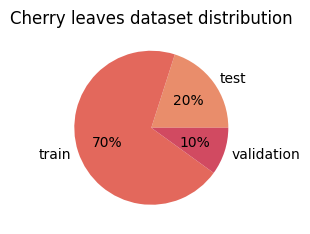

In [10]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('flare')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


### Initialize ImageDataGenerator

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

In [14]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Batch Size

In [15]:
batch_size = 30

### Augment training image set

In [16]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image set

(30, 100, 100, 3)


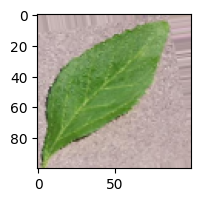

(30, 100, 100, 3)


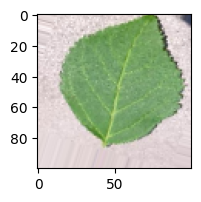

(30, 100, 100, 3)


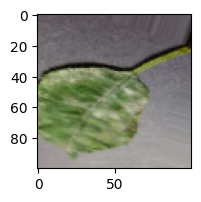

In [17]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment validation image set

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented validation image set

(30, 100, 100, 3)


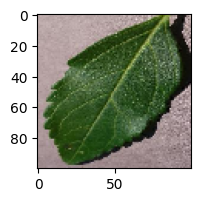

(30, 100, 100, 3)


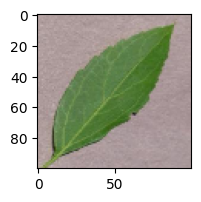

(30, 100, 100, 3)


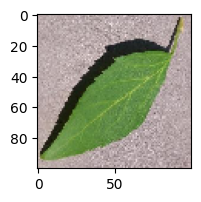

In [19]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment test image set

In [20]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented test image set

(30, 100, 100, 3)


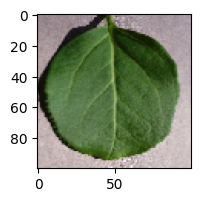

(30, 100, 100, 3)


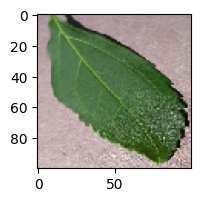

(30, 100, 100, 3)


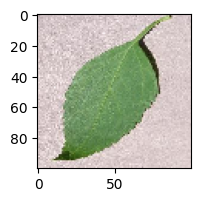

In [21]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

### ML model

In [23]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Model Summary

In [24]:
create_tf_model().summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)      

### Callbacks

- Early stopping
- Model checkpoint

In [25]:
early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=1)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/mildew_model.karas', monitor='val_accuracy', mode='max', save_best_only=False)

### Fit model for training

In [26]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=30,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

Epoch 1/30


98/98 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8342INFO:tensorflow:Assets written to: outputs/v1\mildew_model.karas\assets


INFO:tensorflow:Assets written to: outputs/v1\mildew_model.karas\assets


98/98 [==============================] - 18s 170ms/step - loss: 0.3369 - accuracy: 0.8342 - val_loss: 0.0955 - val_accuracy: 0.9786
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9619INFO:tensorflow:Assets written to: outputs/v1\mildew_model.karas\assets


INFO:tensorflow:Assets written to: outputs/v1\mildew_model.karas\assets


98/98 [==============================] - 14s 142ms/step - loss: 0.1110 - accuracy: 0.9619 - val_loss: 0.0261 - val_accuracy: 0.9929
Epoch 3/30
98/98 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9787INFO:tensorflow:Assets written to: outputs/v1\mildew_model.karas\assets


INFO:tensorflow:Assets written to: outputs/v1\mildew_model.karas\assets


98/98 [==============================] - 17s 170ms/step - loss: 0.0767 - accuracy: 0.9787 - val_loss: 0.0459 - val_accuracy: 0.9857
Epoch 3: early stopping


### Save model

In [27]:
model.save('outputs/v1/mildew_model.karas')

INFO:tensorflow:Assets written to: outputs/v1/mildew_model.karas\assets


INFO:tensorflow:Assets written to: outputs/v1/mildew_model.karas\assets


---

## Model Performace

---

### Model learning curve

Load saved model

In [28]:
model = load_model('outputs/v1/mildew_model.karas')

## Model Evaluation

### Accuracy variables

In [30]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

29/29 [==============================] - 5s 181ms/step - loss: 0.0412 - accuracy: 0.9858
Model accuracy: 98.58%
Model Loss:  0.04119565337896347


### Accuracy- Evaluation of the model on the test set
- Business requirement 2: The performance on the test set meets the project requirements (at least 97% accuracy on test set).

## Classification Reports

In [32]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [33]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------



NameError: name 'y_true' is not defined

### Save evaluation pickle

In [34]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data
Load a random image as PIL

Image shape: (100, 100), Image mode: RGB


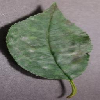

In [35]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [36]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


Predict class probabilities

In [37]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 [==============================] - 0s 123ms/step
powdery_mildew 88.19%
